## Import libraries

In [116]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
NoneType = type(None)

%matplotlib inline

## Data addresses

In [5]:
stations_request = "http://api.gios.gov.pl/pjp-api/rest/station/findAll"
sensors_request = "http://api.gios.gov.pl/pjp-api/rest/station/sensors/{stationId}"
data_request = "http://api.gios.gov.pl/pjp-api/rest/data/getData/{sensorId}"
aqindex_request = "http://api.gios.gov.pl/pjp-api/rest/aqindex/getIndex/{stationId}"

## Get the data

In [6]:
stations = requests.get("http://api.gios.gov.pl/pjp-api/rest/station/findAll").json()
print("Number of available stations: ", len(stations))

Number of available stations:  151


In [7]:
stations_dict = {}
station_ids = []
station_lats = []
station_lons = []
station_geometries = []

for station in stations:
    
    station_ids.append(station["id"])
    station_lats.append(float(station["gegrLat"]))
    station_lons.append(float(station["gegrLon"]))
    station_geometries.append(Point(float(station["gegrLon"]), float(station["gegrLat"])))
    
stations_dict["station_id"] = station_ids
stations_dict["lat"] = station_lats
stations_dict["lon"] = station_lons
stations_dict["station_id"] = station_ids
stations_dict["geometry"] = station_geometries

In [8]:
stations_df = gpd.GeoDataFrame(stations_dict)
stations_df.crs = from_epsg(4326)
stations_df.head()

,station_id,lat,lon,geometry
0,114,51.115933,17.141125,POINT (17.141125 51.115933)
1,129,51.086225,17.012689,POINT (17.012689 51.086225)
2,52,51.204503,16.180513,POINT (16.180513 51.204503)
3,109,50.768729,16.269677,POINT (16.269677 50.768729)
4,38,50.433493,16.653660,POINT (16.65366 50.433493)


## Plot stations on map

In [40]:
stations_map = folium.Map([52, 19], zoom_start=6, tiles='Stamen Terrain')

points = folium.features.GeoJson(stations_df.to_json())

stations_map.add_child(points)
stations_map.add_child(HeatMap([[row["lat"], row["lon"]] for name, row in stations_df.iterrows()]))
stations_map

## Check available readings for stations

In [43]:
sensors_dict = {}
stations_ids = []
sensors_ids = []
sensors_param = []

for station in stations:
    
    station_id = station["id"]
    sensors = requests.get("http://api.gios.gov.pl/pjp-api/rest/station/sensors/{}".format(station_id)).json()
    
    for sensor in sensors:

        stations_ids.append(sensor["stationId"])
        sensors_ids.append(sensor["id"])
        sensors_param.append(sensor["param"]["paramCode"])
    
sensors_dict["station_id"] = stations_ids
sensors_dict["sensor_id"] = sensors_ids
sensors_dict["parameter"] = sensors_param\

In [44]:
sensors_df = pd.DataFrame(sensors_dict)
sensors_df.head()

,station_id,sensor_id,parameter
0,114,642,NO2
1,114,644,O3
2,129,737,CO
3,129,740,NO2
4,129,744,PM2.5


## Check data

In [105]:
def get_sensor_readings(row):
    
    sensor_id = row["sensor_id"]
    data_json = requests.get("http://api.gios.gov.pl/pjp-api/rest/data/getData/{}".format(sensor_id)).json()
    count = 0
    try:
        data = data_json["values"][count]["value"]
        while isinstance(data, NoneType):
            data = data_json["values"][count]["value"]
            count+=1
        return data
    except:
        return np.NaN

In [106]:
sensors_df['data'] = sensors_df.apply(get_sensor_readings, axis=1)
sensors_df.head()

,station_id,sensor_id,parameter,data
0,114,642,NO2,33.11480
1,114,644,O3,27.84060
2,129,737,CO,1124.57000
3,129,740,NO2,70.67550
4,129,744,PM2.5,5.78901


In [107]:
available_parameters = list(sensors_df.parameter.unique())
available_parameters

['NO2', 'O3', 'CO', 'PM2.5', 'PM10', 'C6H6', 'SO2']

In [123]:
def get_param_df(parameter=''):
    
    param_df = sensors_df[sensors_df["parameter"]=="{}".format(parameter)]
    param_df = gpd.GeoDataFrame(pd.merge(param_df, stations_df, on='station_id'))
    param_df.dropna(inplace=True)
    param_df.crs = from_epsg(4326)
    
    return param_df

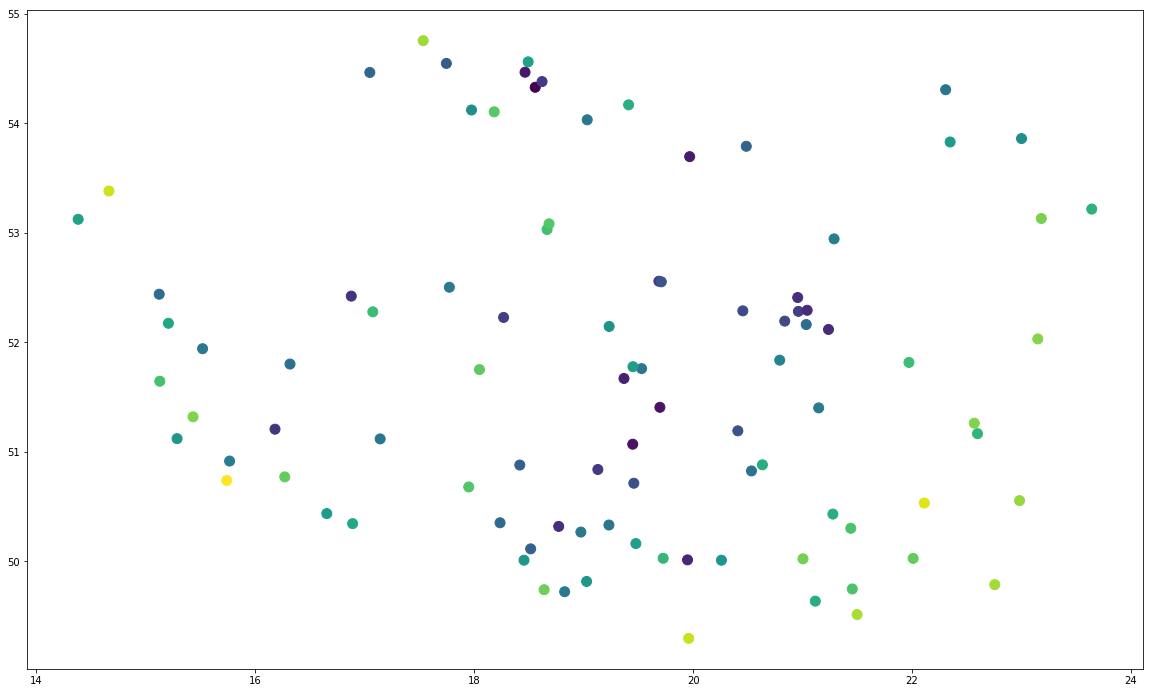

In [126]:
get_param_df("O3").plot('data', figsize=(20,20), markersize=100)

In [122]:
import bokeh

ModuleNotFoundError: No module named 'bokeh'